# Normalize data to MNI template

This example covers the normalization of data. Some people prefer to normalize the data during the preprocessing, just before smoothing. I prefer to do the 1st-level analysis completely in subject space and only normalize the contrasts for the 2nd-level analysis. But both approaches are fine.

For the current example, we will take the computed 1st-level contrasts from the previous experiment (again once done with fwhm=4mm and fwhm=8mm) and normalize them into MNI-space. To show two different approaches, we will do the normalization once with ANTs and once with SPM.

## Normalization with ANTs

The normalization with ANTs requires that you first compute the transformation matrix that would bring the anatomical images of each subject into template space. Depending on your system this might take a few hours per subject. To facilitate this step, the transformation matrix is already computed for the T1 images.

## Imports (ANTs)

First, we need to import all the modules we later want to use.

In [1]:
from os.path import join as opj
from nipype import Workflow, Node, MapNode
from nipype.interfaces.ants import ApplyTransforms
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.interfaces.fsl import Info

## Experiment parameters (ANTs)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. And remember that we decided to run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left-handed (see [this section](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Special-case)).

In [10]:
experiment_dir = '/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized'
output_dir = 'datasink'

# list of subject identifiers (remember we use only right handed subjects)
subject_list = ['%02d'%i for i in range(1, 23)]

# Template to normalize to
template = '/home/neuro/Data/Visual_search_task/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

## Specify Nodes (ANTs)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [11]:
# Apply Transformation - applies the normalization matrix to contrast images
apply2con = MapNode(ApplyTransforms(args='--float',
                                    input_image_type=3,
                                    interpolation='BSpline',
                                    invert_transform_flags=[False],
                                    num_threads=1,
                                    reference_image=template,
                                    terminal_output='file'),
                    name='apply2con', iterfield=['input_image'])

## Specify input & output stream (ANTs)

Specify where the input data can be found & where and how to save the output data.

In [12]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id']), name="infosource")
infosource.iterables = [('subject_id', subject_list)]

# SelectFiles - to grab the data (alternativ to DataGrabber)
input_data_dir = '/home/neuro/Result/Visual_search_task/'
templates = {'con': opj('1st_analysis/analysis_result/datasink/1stLevel/', 'sub-{subject_id}', 'con_00??.nii'),
             'transform': opj('preproc_working_dir/warp_field/antsdir/transform/', '{subject_id}', 'transformComposite.h5')}
selectfiles = Node(SelectFiles(templates, base_directory=input_data_dir, sort_filelist=True), name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir, container=output_dir), name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
subjFolders = [('_apply2con%s/' % (i), '') for i in range(23)] # number of contrast used in 1stlevel an.
substitutions.extend(subjFolders)
datasink.inputs.substitutions = substitutions

## Specify Workflow (ANTs)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [13]:
# Initiation of the ANTs normalization workflow
antsflow = Workflow(name='antsflow', base_dir=experiment_dir)

# Connect up the ANTs normalization components
antsflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                  (selectfiles, apply2con, [('con', 'input_image'),
                                            ('transform', 'transforms')]),
                  (apply2con, datasink, [('output_image', 'norm_ants.@con')]),
                  ])

## Visualize the workflow (ANTs)

It always helps to visualize your workflow.

In [14]:
# Create ANTs normalization graph
antsflow.write_graph(graph2use='flat', format='png', simple_form=True)

211118-10:36:57,5 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/antsflow/graph.png (graph2use=flat, simple_form=True).


'/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/antsflow/graph.png'

##  Run the Workflow (ANTs)

Now that everything is ready, we can run the ANTs normalization workflow. Change ``n_procs`` to the number of jobs/cores you want to use.

In [15]:
antsflow.run('MultiProc', plugin_args={'n_procs': 4})

211118-10:38:43,522 nipype.workflow INFO:
	 Workflow antsflow settings: ['check', 'execution', 'logging', 'monitoring']
211118-10:38:43,758 nipype.workflow INFO:
	 Running in parallel.
211118-10:38:43,761 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 22 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211118-10:38:43,820 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/antsflow/_subject_id_22/selectfiles".
211118-10:38:43,822 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/antsflow/_subject_id_21/selectfiles".
211118-10:38:43,824 nipype.workflow INFO:
	 [Node] Setting-up "antsflow.selectfiles" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/antsflow/_subject_id_20/selectfiles".
211118-10:38:43,825 nipype.workflow INFO:
	

RuntimeError: Workflow did not execute cleanly. Check log for details

# Normalization with SPM12

The normalization with SPM12 is rather straightforward. The only thing we need to do is run the Normalize12 module. **So let's start!**

## Imports (SPM12)

First, we need to import all the modules we later want to use.

In [16]:
from os.path import join as opj
from nipype.interfaces.spm import Normalize12
from nipype.interfaces.utility import IdentityInterface
from nipype.interfaces.io import SelectFiles, DataSink
from nipype.algorithms.misc import Gunzip
from nipype import Workflow, Node

## Experiment parameters (SPM12)

It's always a good idea to specify all parameters that might change between experiments at the beginning of your script. And remember that we decided to run the group analysis without subject ``sub-01``, ``sub-06`` and ``sub-10`` because they are left-handed (see [this section](https://miykael.github.io/nipype_tutorial/notebooks/example_1stlevel.html#Special-case)).

In [17]:
experiment_dir = '/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized'
output_dir = 'datasink_spm'

# list of subject identifiers
subject_list = ['%02d'%i for i in range(1, 23)]
subject_list.remove('11')

template = '/opt/spm12-r7219/spm12_mcr/spm12/tpm/TPM.nii'

## Specify Nodes (SPM12)

Initiate all the different interfaces (represented as nodes) that you want to use in your workflow.

In [19]:
# Normalize - normalizes functional and structural images to the MNI template
normalize = Node(Normalize12(jobtype='estwrite',
                             tpm=template,
                             write_voxel_sizes=[1, 1, 1]), name="normalize")

stty: 'standard input': Inappropriate ioctl for device


## Specify input & output stream (SPM12)

Specify where the input data can be found & where and how to save the output data.

In [20]:
# Infosource - a function free node to iterate over the list of subject names
infosource = Node(IdentityInterface(fields=['subject_id']), name="infosource")
infosource.iterables = [('subject_id', subject_list)]

templates = {'con':  opj('1st_analysis/analysis_result/datasink/1stLevel/', 'sub-{subject_id}', 'con_00??.nii'),
             'anat': '/home/neuro/Data/Visual_search_task/BIDS_data/sub-{subject_id}/ses-test/anat/sub-{subject_id}_ses-test_anat_sT1W.nii'}

input_data_dir = '/home/neuro/Result/Visual_search_task/'
selectfiles = Node(SelectFiles(templates, base_directory=input_data_dir, sort_filelist=True),
                   name="selectfiles")

# Datasink - creates output folder for important outputs
datasink = Node(DataSink(base_directory=experiment_dir, container=output_dir),
                name="datasink")

# Use the following DataSink output substitutions
substitutions = [('_subject_id_', 'sub-')]
datasink.inputs.substitutions = substitutions

## Specify Workflow (SPM12)

Create a workflow and connect the interface nodes and the I/O stream to each other.

In [24]:
# Specify Normalization-Workflow & Connect Nodes
spmflow = Workflow(name='spmflow')
spmflow.base_dir = opj(experiment_dir)

# Connect up SPM normalization components
spmflow.connect([(infosource, selectfiles, [('subject_id', 'subject_id')]),
                 (selectfiles, normalize, [('con', 'apply_to_files')]),
                 (selectfiles, normalize, [('anat', 'image_to_align')]),
                 (normalize, datasink, [('normalized_files', 'norm_spm.@files'),
                                        ('normalized_image', 'norm_spm.@image')])
                 ])

## Visualize the workflow (SPM12)

It always helps to visualize your workflow.

In [25]:
# Create SPM normalization graph
spmflow.write_graph(graph2use='colored', format='png', simple_form=True)

211118-13:09:14,257 nipype.workflow INFO:
	 Generated workflow graph: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/graph.png (graph2use=colored, simple_form=True).


'/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/graph.png'

##  Run the Workflow (SPM12)

In [26]:
spmflow.run('MultiProc', plugin_args={'n_procs': 4})

211118-13:09:24,329 nipype.workflow INFO:
	 Workflow spmflow settings: ['check', 'execution', 'logging', 'monitoring']
211118-13:09:24,533 nipype.workflow INFO:
	 Running in parallel.
211118-13:09:24,536 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 21 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211118-13:09:24,597 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_22/selectfiles".
211118-13:09:24,598 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_21/selectfiles".
211118-13:09:24,600 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_20/selectfiles".
211118-13:09:24,602 nipype.workflow INFO:
	 [Node]

stty: 'standard input': Inappropriate ioctl for device


211118-13:11:42,671 nipype.workflow INFO:
	 [Job 10] Completed (spmflow.normalize).
211118-13:11:42,672 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 18 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:11:42,715 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_19/datasink".
211118-13:11:42,757 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:11:42,764 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_19/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-19/

stty: 'standard input': Inappropriate ioctl for device


211118-13:11:46,490 nipype.workflow INFO:
	 [Node] Finished "spmflow.normalize".


stty: 'standard input': Inappropriate ioctl for device


211118-13:11:46,674 nipype.workflow INFO:
	 [Job 1] Completed (spmflow.normalize).
211118-13:11:46,675 nipype.workflow INFO:
	 [Job 4] Completed (spmflow.normalize).
211118-13:11:46,676 nipype.workflow INFO:
	 [Job 12] Completed (spmflow.selectfiles).
211118-13:11:46,678 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 19 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * spmflow.normalize
211118-13:11:46,715 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_22/datasink".
211118-13:11:46,717 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_21/datasink".
211118-13:11:46,720 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.normalize" in "/home/neuro/Result/Visual_search

stty: 'standard input': Inappropriate ioctl for device


211118-13:11:48,676 nipype.workflow INFO:
	 [Job 7] Completed (spmflow.normalize).
211118-13:11:48,677 nipype.workflow INFO:
	 [Job 2] Completed (spmflow.datasink).
211118-13:11:48,678 nipype.workflow INFO:
	 [Job 5] Completed (spmflow.datasink).
211118-13:11:48,680 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 17 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * spmflow.normalize
211118-13:11:48,717 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_20/datasink".
211118-13:11:48,719 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_17/selectfiles".
211118-13:11:48,721 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.selectfiles" in "/home/neuro/Result/Visual_sea

stty: 'standard input': Inappropriate ioctl for device


211118-13:14:08,811 nipype.workflow INFO:
	 [Job 16] Completed (spmflow.normalize).
211118-13:14:08,812 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 14 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:14:08,864 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_17/datasink".
211118-13:14:08,910 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:14:08,912 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_17/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-17/

stty: 'standard input': Inappropriate ioctl for device


211118-13:14:13,315 nipype.workflow INFO:
	 [Node] Running "normalize" ("nipype.interfaces.spm.preprocess.Normalize12")
211118-13:14:14,817 nipype.workflow INFO:
	 [Job 13] Completed (spmflow.normalize).
211118-13:14:14,819 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 13 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:14:14,877 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_18/datasink".
211118-13:14:14,924 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:14:14,925 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_18/wcon_000

stty: 'standard input': Inappropriate ioctl for device


211118-13:15:10,871 nipype.workflow INFO:
	 [Job 19] Completed (spmflow.normalize).
211118-13:15:10,873 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 12 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:15:10,914 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_16/datasink".
211118-13:15:10,956 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:15:10,957 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_16/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-16/

stty: 'standard input': Inappropriate ioctl for device


211118-13:15:36,895 nipype.workflow INFO:
	 [Job 22] Completed (spmflow.normalize).
211118-13:15:36,897 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 11 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:15:36,950 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_15/datasink".
211118-13:15:36,999 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:15:37,1 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_15/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-15/wc

stty: 'standard input': Inappropriate ioctl for device


211118-13:16:25,867 nipype.workflow INFO:
	 [Node] Finished "spmflow.normalize".
211118-13:16:26,942 nipype.workflow INFO:
	 [Job 25] Completed (spmflow.normalize).
211118-13:16:26,944 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 10 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:16:26,986 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_14/datasink".
211118-13:16:27,35 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:16:27,37 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_14/wcon_0001.nii -> /home/neuro/Result/Visual_search

stty: 'standard input': Inappropriate ioctl for device


211118-13:16:38,954 nipype.workflow INFO:
	 [Job 28] Completed (spmflow.normalize).
211118-13:16:38,956 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 9 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:16:39,1 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_13/datasink".
211118-13:16:39,44 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:16:39,45 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_13/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-13/wcon_

stty: 'standard input': Inappropriate ioctl for device


211118-13:17:37,9 nipype.workflow INFO:
	 [Job 31] Completed (spmflow.normalize).
211118-13:17:37,11 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 8 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:17:37,53 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_12/datasink".
211118-13:17:37,107 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:17:37,109 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_12/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-12/wcon_

stty: 'standard input': Inappropriate ioctl for device


211118-13:18:13,43 nipype.workflow INFO:
	 [Job 34] Completed (spmflow.normalize).
211118-13:18:13,45 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 7 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:18:13,85 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_10/datasink".
211118-13:18:13,130 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:18:13,131 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_10/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-10/wcon

stty: 'standard input': Inappropriate ioctl for device


211118-13:18:51,78 nipype.workflow INFO:
	 [Job 37] Completed (spmflow.normalize).
211118-13:18:51,80 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 6 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:18:51,124 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_09/datasink".
211118-13:18:51,165 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:18:51,166 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_09/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-09/wco

stty: 'standard input': Inappropriate ioctl for device


211118-13:18:55,82 nipype.workflow INFO:
	 [Job 40] Completed (spmflow.normalize).
211118-13:18:55,84 nipype.workflow INFO:
	 [Job 48] Completed (spmflow.selectfiles).
211118-13:18:55,85 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 6 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:18:55,136 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_08/datasink".
211118-13:18:55,139 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.normalize" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_05/normalize".
211118-13:18:55,180 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:18:55,182 nipype.interface INFO:
	 sub: /home

stty: 'standard input': Inappropriate ioctl for device


211118-13:20:23,168 nipype.workflow INFO:
	 [Job 43] Completed (spmflow.normalize).
211118-13:20:23,169 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 4 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:20:23,211 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_07/datasink".
211118-13:20:23,255 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:20:23,257 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_07/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-07/w

stty: 'standard input': Inappropriate ioctl for device


211118-13:20:39,182 nipype.workflow INFO:
	 [Job 46] Completed (spmflow.normalize).
211118-13:20:39,183 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 3 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:20:39,239 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_06/datasink".
211118-13:20:39,287 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:20:39,289 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_06/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-06/w

stty: 'standard input': Inappropriate ioctl for device


211118-13:21:49,251 nipype.workflow INFO:
	 [Job 49] Completed (spmflow.normalize).
211118-13:21:49,253 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 2 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:21:49,293 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_05/datasink".
211118-13:21:49,335 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:21:49,336 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_05/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-05/w

stty: 'standard input': Inappropriate ioctl for device


211118-13:21:59,261 nipype.workflow INFO:
	 [Job 52] Completed (spmflow.normalize).
211118-13:21:59,263 nipype.workflow INFO:
	 [MultiProc] Running 3 tasks, and 1 jobs ready. Free memory (GB): 11.70/12.30, Free processors: 1/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:21:59,303 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_04/datasink".
211118-13:21:59,345 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:21:59,346 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_04/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-04/w

stty: 'standard input': Inappropriate ioctl for device


211118-13:22:41,298 nipype.workflow INFO:
	 [Job 55] Completed (spmflow.normalize).
211118-13:22:41,300 nipype.workflow INFO:
	 [MultiProc] Running 2 tasks, and 1 jobs ready. Free memory (GB): 11.90/12.30, Free processors: 2/4.
                     Currently running:
                       * spmflow.normalize
                       * spmflow.normalize
211118-13:22:41,347 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_03/datasink".
211118-13:22:41,394 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:22:41,395 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_03/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-03/wcon_0001.nii
211118-13:22:41,415 nipype.int

stty: 'standard input': Inappropriate ioctl for device


211118-13:23:03,320 nipype.workflow INFO:
	 [Job 58] Completed (spmflow.normalize).
211118-13:23:03,322 nipype.workflow INFO:
	 [MultiProc] Running 1 tasks, and 1 jobs ready. Free memory (GB): 12.10/12.30, Free processors: 3/4.
                     Currently running:
                       * spmflow.normalize
211118-13:23:03,363 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_02/datasink".
211118-13:23:03,405 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:23:03,407 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_02/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-02/wcon_0001.nii
211118-13:23:03,428 nipype.interface INFO:
	 sub: /home/neuro/Result/Visu

stty: 'standard input': Inappropriate ioctl for device


211118-13:23:57,376 nipype.workflow INFO:
	 [Job 61] Completed (spmflow.normalize).
211118-13:23:57,383 nipype.workflow INFO:
	 [MultiProc] Running 0 tasks, and 1 jobs ready. Free memory (GB): 12.30/12.30, Free processors: 4/4.
211118-13:23:57,422 nipype.workflow INFO:
	 [Node] Setting-up "spmflow.datasink" in "/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/spmflow/_subject_id_01/datasink".
211118-13:23:57,469 nipype.workflow INFO:
	 [Node] Running "datasink" ("nipype.interfaces.io.DataSink")
211118-13:23:57,471 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_subject_id_01/wcon_0001.nii -> /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-01/wcon_0001.nii
211118-13:23:57,496 nipype.interface INFO:
	 sub: /home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/_s

# Comparison between ANTs and SPM normalization

Now that we ran the normalization with ANTs and SPM, let us compare their output.

In [36]:
from nilearn.plotting import plot_stat_map
from nilearn.plotting import plot_glass_brain
anatimg = '/home/neuro/Data/ds000114/derivatives/fmriprep/mni_icbm152_nlin_asym_09c/1mm_T1.nii.gz'

First, let's compare the normalization of the **anatomical** images:

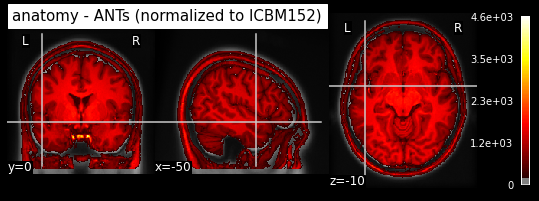

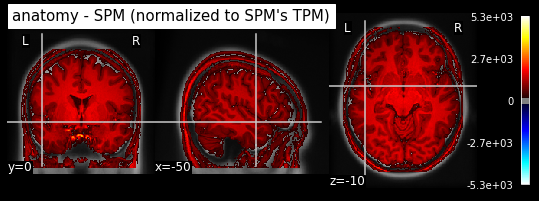

In [30]:
plot_stat_map(
    '/home/neuro/Result/Visual_search_task/preproc_working_dir/warp_field/antsdir/warped_image/01/transform_Warped.nii.gz',
    title='anatomy - ANTs (normalized to ICBM152)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))
plot_stat_map(
    '/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-01/wsub-01_ses-test_anat_sT1W.nii',
    title='anatomy - SPM (normalized to SPM\'s TPM)', bg_img=anatimg,
    threshold=200, display_mode='ortho', cut_coords=(-50, 0, -10))

And what about the **contrast** images for **Finger > others**?

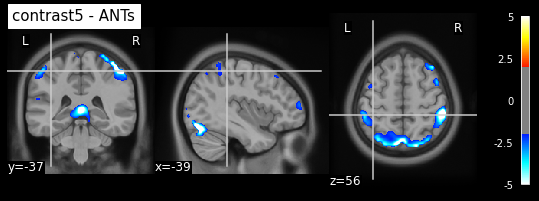

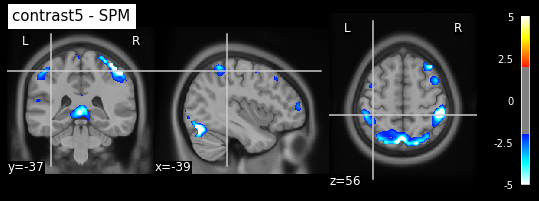

In [35]:
plot_stat_map(
    '/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_ants/norm_ants/sub-01/con_0006_trans.nii', title='contrast5 - ANTs',
    bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56))
plot_stat_map(
    '/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-01/wcon_0006.nii', title='contrast5 - SPM',
    bg_img=anatimg, threshold=2, vmax=5, display_mode='ortho', cut_coords=(-39, -37, 56))

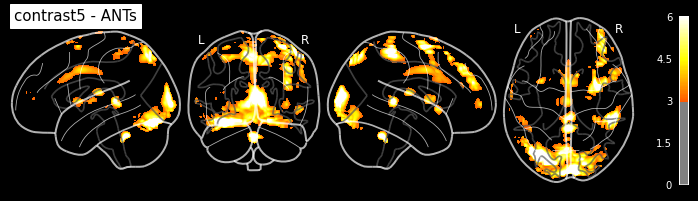

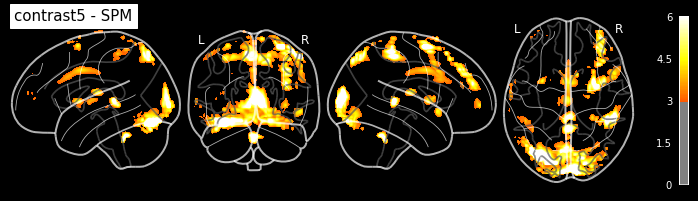

In [38]:
plot_glass_brain(
    '/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_ants/norm_ants/sub-01/con_0006_trans.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - ANTs')
plot_glass_brain(
    '/home/neuro/Result/Visual_search_task/1st_analysis/analysis_result/1st_normalized/datasink_spm/norm_spm/sub-01/wcon_0006.nii', colorbar=True,
    threshold=3, display_mode='lyrz', black_bg=True, vmax=6, title='contrast5 - SPM')